In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.utils.data
import os
import multiprocessing
from tqdm import tqdm

### Datasets and Dataloaders (understand the dimensions)

Feature batch shape: torch.Size([2, 3, 512, 764])
Labels batch shape: torch.Size([2])


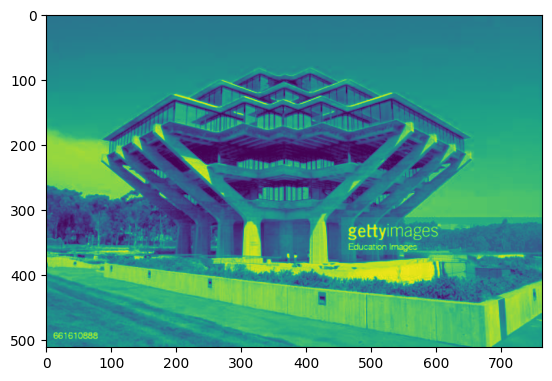

Label: 1
torch.Size([1, 512, 2292])


In [3]:
transform = T.Compose([
    T.Resize((512, 764)),
    T.ToTensor()
])

training_data = datasets.ImageFolder("data/UCSD_images", transform=transform)

train_dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

images, labels = next(iter(train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].squeeze()
label = labels[0]
plt.imshow(img[0]) # index 0: image has RGB channels, show only one
plt.show()
print(f"Label: {label}")

img = img.view(1, img.size(1), -1) # stacking all rgb channels together
print(img.size())

#### understand tensor axis

In [107]:
a = torch.Tensor([[[1,2,3], [1,2,3]], 
                  [[4,5,6], [7,8,9]]])
print(a.size())
print(a)
print(a.mean(1))

torch.Size([2, 2, 3])
tensor([[[1., 2., 3.],
         [1., 2., 3.]],

        [[4., 5., 6.],
         [7., 8., 9.]]])
tensor([[1.0000, 2.0000, 3.0000],
        [5.5000, 6.5000, 7.5000]])


### CNN Layers Functionality

<img src='images/cnn_layers_blueprint.jpeg' height=80% width=80% />


### Example CNN Structure

We have a series of 3 convolutional parts constituted of a convolutional layer, a max pooling operation that halves the input shape, and then a ReLU activation.

The number of feature maps in the sequence varies from 16 -> 32 -> 64. In other words, we are working with feature maps with a smaller height and width (because we keep applying max pooling) but with a higher channel count. This is very typical and helps the network with abstraction.

Then, we have a Flatten layer that flattens our 64 feature maps (coming from the last conv layer before the flattening) into one long vector. Assuming that the input is 32x32, this vector will contain 1024 numbers.

Finally, we have an MLP made of fully-connected layers that combines all the information extracted by the convolutional part and outputs one number for each class (logits). We first compress the 1024-long array into an embedding of 128 numbers, and then from there to the number of classes we have.

In [39]:
class MyCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.model = nn.Sequential(
          # First conv + maxpool + relu
          nn.Conv2d(3, 16, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),

          # Second conv + maxpool + relu
          nn.Conv2d(16, 32, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),

          # Third conv + maxpool + relu
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),

          # Flatten feature maps
          nn.Flatten(),

          # Fully connected layers. This assumes
          # that the input image was 32x32
          # output from the last conv layer is (64, 4, 4)
          nn.Linear(1024, 500),
          nn.Dropout(0.5),
          nn.ReLU(),
          nn.Linear(500, n_classes)
        )

    def forward(self, x):
        # nn.Sequential will call the layers 
        # in the order they have been inserted
        return self.model(x)

### Image Augmentation

A typical training augmentation pipeline is represented in this diagram.


<img src='images/image_augmentation.jpeg' height=100% width=80% />

In [4]:
import torchvision.transforms as T

train_transforms = T.Compose(
    [
        # The size here depends on your application. Here let's use 256x256
        T.Resize(256),
        # Let's apply random affine transformations (rotation, translation, shear)
        # (don't overdo here!)
        T.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
        # Color modifications. Here I exaggerate to show the effect 
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        # Apply an horizontal flip with 50% probability (i.e., if you pass
        # 100 images through around half of them will undergo the flipping)
        T.RandomHorizontalFlip(0.5),
        # Finally take a 224x224 random part of the image
        T.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),
        # Converts (H x W x C) in the range [0, 255] to a torch.FloatTensor 
        # of shape (C x H x W) in the range [0.0, 1.0] 
        T.ToTensor(),
        # Normalize a tensor image with mean and standard deviation. here to the range [-1,1]
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

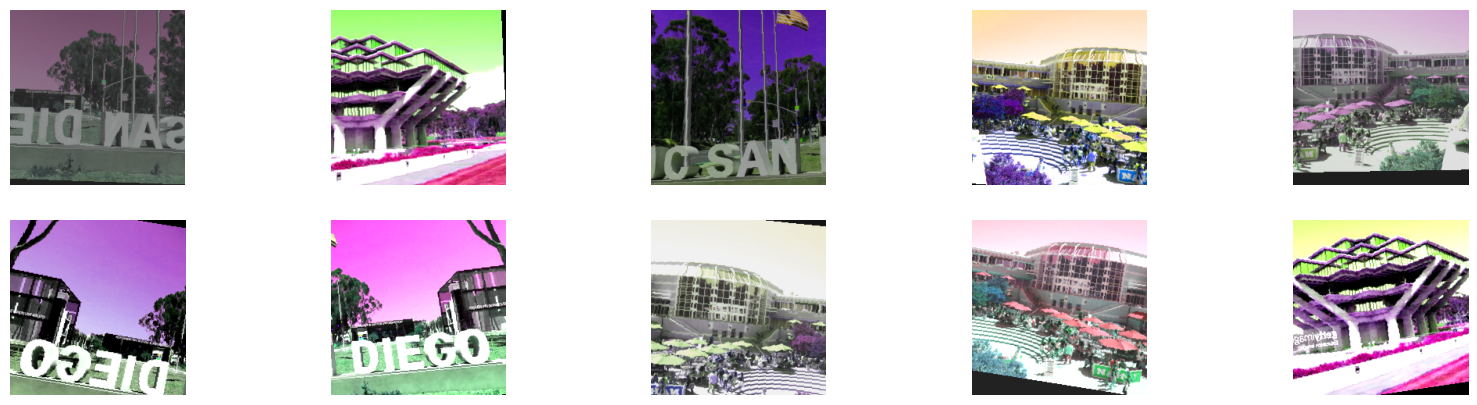

In [34]:
from torchvision import datasets
import torch.utils.data

train_data = datasets.ImageFolder(root="data/UCSD_images", transform=train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, drop_last=False)

# un-normalize and display image
def imshow(img, sub):
    img = img * 0.5 + 0.5 # un-normalize
    sub.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor to image
    sub.axis("off")
    
fig, subs = plt.subplots(2, 5, figsize=(20,5))
for i, sub in enumerate(subs.flatten()):
    dataiter = iter(train_data_loader)
    images, labels = dataiter.next()
    imshow(images[0], sub)

During validation and test you typically do not want to apply image augmentation (which is needed for training). Hence, here is a typical transform pipeline for validation and test that can be paired with the pipeline above:

In [ ]:
testval_transforms = T.Compose(
    [
        # The size here depends on your application. Here let's use 256x256
        T.Resize(256),
        # Let's take the central 224x224 part of the image
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

### AutoAugment Transforms

there is also option to use auto augmentation defined in torchvision

In [37]:
auto_augment_transforms = T.Compose(
    [
        T.Resize(256),
        T.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),
        T.RandomHorizontalFlip(0.5),
        # auto augmentation
        T.RandAugment(num_ops=3, magnitude=15, interpolation=T.InterpolationMode.BILINEAR),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

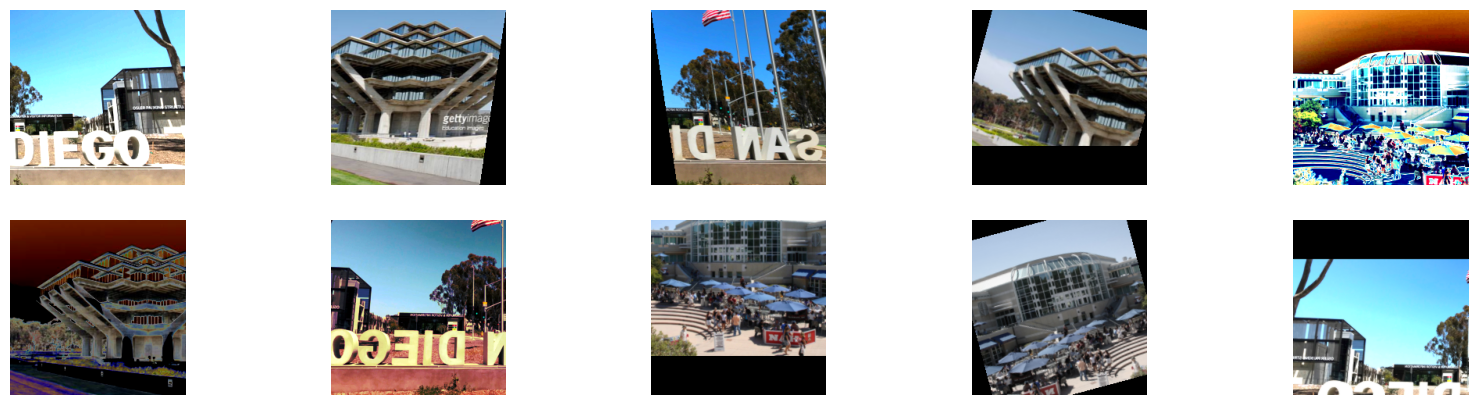

In [38]:
train_data = datasets.ImageFolder(root="data/UCSD_images", transform=auto_augment_transforms)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, drop_last=False)

# un-normalize and display image
def imshow(img, sub):
    img = img * 0.5 + 0.5 # un-normalize
    sub.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor to image
    sub.axis("off")
    
fig, subs = plt.subplots(2, 5, figsize=(20,5))
for i, sub in enumerate(subs.flatten()):
    dataiter = iter(train_data_loader)
    images, labels = dataiter.next()
    imshow(images[0], sub)

### Batch Normalization

In [ ]:
self.conv1 = nn.Sequential(
  nn.Conv2d(3, 16, kernel_size=3, padding=1),
  nn.BatchNorm2d(16), # take number of output channel as argument
  nn.MaxPool2d(2, 2),
  nn.ReLU(),
  nn.Dropout2d(0.2)
)

self.mlp = nn.Sequential(
  nn.Linear(1024, 500),
  nn.BatchNorm1d(500),
  nn.ReLU(),
  nn.Dropout(0.5)
)

# Transfer Learning

A normal CNN extracts more and more abstract features the deeper you go in the network. This means that the initial layers, which extract elementary features such as edges and colors, are probably pretty general and can be applied similarly on many different datasets. Instead, the last layers (especially the fully-connected layers) are highly specialized in the task they have been trained on.

The transfer-learning workflow consists of taking a pre-trained model, freezing some of the initial layers and freeing or substituting some late layers, then training on our dataset.

<center><img src="images/fine_tune_quadrants.png" width="80%"></center>

### Helper Function

In [5]:
import livelossplot

data_path = ""

def set_data_path(path):
    if os.path.exists(path):
        global data_path
        data_path = path
        return None
    raise Exception("no such path: {}".format(path))

def compute_mean_and_std():
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """
    cache_file = "mean_and_std.pt"
    if os.path.exists(cache_file):
        d = torch.load(cache_file)
        print("Reusing cached mean:{} and std:{}".format(d["mean"], d["std"]))
        return d["mean"], d["std"]
    
    if not os.path.exists(data_path):
        raise Exception("no such path: {}".format(data_path))
    
    ds = datasets.ImageFolder(data_path, transform=T.Compose([T.ToTensor()]))
    dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=multiprocessing.cpu_count())

    mean = 0.0
    std = 0.0
    for image, _ in tqdm(dl, total=len(ds), desc="Computing mean and std", ncols=80):
        mean += image.squeeze().mean([1,2])
        std += image.squeeze().std([1,2])
    mean = mean / len(dl.dataset)
    std = std / len(dl.dataset)
    
    print(f"Dataset mean: {mean}, std: {std}")
    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std

def get_transforms(rand_augment_magnitude):
    """
    Get transform needed for image augmentation
    """
    mean, std = compute_mean_and_std()
    return {
        "train": T.Compose(
            [
                T.Resize(256),
                T.RandomCrop(224),
                T.RandomHorizontalFlip(0.5),
                # rand_augment_magnitude should be tuned through experiment
                T.RandAugment(
                    num_ops=2,
                    magnitude=rand_augment_magnitude,
                    interpolation=T.InterpolationMode.BILINEAR,
                ),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        )
    }

def get_data_loaders_local(batch_size: int = 32,
                     valid_size: float = 0.2, 
                     num_workers: int = -1, 
                     limit: int = -1, 
                     rand_augment_magnitude: int = 9):
    """
    Create and returns the train_one_epoch, validation and test data loaders.

    :param batch_size: size of the mini-batches
    :param valid_size: fraction of the dataset to use for validation. For example 0.2
                       means that 20% of the dataset will be used for validation
    :param num_workers: number of workers to use in the data loaders. Use -1 to mean
                        "use all my cores"
    :param limit: maximum number of data points to consider
    :return a dictionary with 3 keys: 'train_one_epoch', 'valid' and 'test' containing respectively the
            train_one_epoch, validation and test data loaders
    """

    if num_workers == -1:
        num_workers = multiprocessing.cpu_count()

    # Initialize
    data_loaders = {"train": None, "valid": None, "test": None}
    data_transforms = get_transforms(rand_augment_magnitude)

    # Create train datasets
    train_data = datasets.ImageFolder(data_path, transform=data_transforms["train"])
    # The validation dataset is a split from the train dataset
    valid_data = datasets.ImageFolder(data_path,transform=data_transforms["valid"])

    # obtain training indices that will be used for validation
    n_tot = len(train_data)
    indices = torch.randperm(n_tot)

    # If requested, limit the number of data points to consider
    if limit > 0:
        indices = indices[:limit]
        n_tot = limit

    split = int(math.ceil(valid_size * n_tot))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # prepare data loaders
    data_loaders["train"] = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
    data_loaders["valid"] = torch.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )

    return data_loaders

def get_data_loaders_CIFAR10(transform,
                             batch_size: int = 64,
                             valid_size: float = 0.2, 
                             num_workers: int = -1):
    # initialize empty data loaders dict
    data_loaders = {"train": None, "valid": None, "test": None}
    
    if num_workers == -1:
        num_workers = multiprocessing.cpu_count()

    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)

    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    data_loaders["train"] = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    data_loaders["valid"] = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )
    
    test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
    data_loaders["test"] = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return data_loaders

def train_one_epoch(train_dataloader, model, optimizer, loss):
    """
    Performs one epoch of training
    """
    # Move model to GPU if available
    if torch.cuda.is_available():
        model.cuda()

    # Set the model in training mode
    # (so all layers that behave differently between training and evaluation,
    # like batchnorm and dropout, will select their training behavior)
    model.train()

    train_loss = 0.0
    for batch_idx, (data, target) in tqdm(
        enumerate(train_dataloader),
        desc="Training",
        total=len(train_dataloader),
        leave=True,
        ncols=80,
    ):
        # move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. clear the gradients of all optimized variables
        optimizer.zero_grad()
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # 3. calculate the loss
        loss_value = loss(output, target)
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()
        # 5. perform a single optimization step (parameter update)
        optimizer.step()
        # update average training loss
        train_loss += (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)

    return train_loss

def valid_one_epoch(valid_dataloader, model, loss):
    """
    Validate at the end of one epoch
    """
    # During validation we don't need to accumulate gradients
    with torch.no_grad():
        # If the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model.cuda()

        # set the model to evaluation mode
        model.eval()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(valid_dataloader),
            desc="Validating",
            total=len(valid_dataloader),
            leave=True,
            ncols=80,
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # 2. calculate the loss
            loss_value = loss(output, target)
            # Calculate average validation loss
            valid_loss += (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)

    return valid_loss

def optimize(data_loaders, 
             model, 
             optimizer, 
             loss, 
             n_epochs, 
             save_path, 
             interactive_tracking=False):

    def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
        """Add title xlabel and legend to single chart"""
        ax.set_title(group_name)
        ax.set_xlabel(x_label)
        ax.legend(loc="center right")
        
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = livelossplot.PlotLosses(outputs=[\
                        livelossplot.outputs.MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a plateau
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", verbose=True, threshold=0.01
    )

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(data_loaders["train"], model, optimizer, loss)
        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or ((valid_loss_min - valid_loss) / valid_loss_min > 0.01):
            # Save the weights to save_path and update valid_loss_min
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        #scheduler.step(valid_loss)

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()
            
def test_one_epoch(test_dataloader, model, loss):
    test_loss = 0.
    correct = 0.
    total = 0.

    with torch.no_grad():
        # if the GPU is available, move the model to the GPU
        if torch.cuda.is_available():
            model = model.cuda()
            
        model.eval()
        
        # Loop over test dataset
        # We also accumulate predictions and targets so we can return them
        preds = []
        actuals = []
        
        for batch_idx, (data, target) in tqdm(
                enumerate(test_dataloader),
                desc='Testing',
                total=len(test_dataloader),
                leave=True,
                ncols=80
        ):
            # move data to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # 1. forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # 2. calculate the loss, get a new tensor detached from the graph
            loss_value = loss(logits, target).detach()
            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss_value.data.item() - test_loss))
            # convert logits to predicted class
            # NOTE: the predicted class is the index of the max of the logits
            pred = logits.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += torch.sum(torch.squeeze(pred.eq(target.data.view_as(pred))).cpu())
            total += data.size(0)
            
            preds.extend(pred.data.cpu().numpy().squeeze())
            actuals.extend(target.data.view_as(pred).cpu().numpy().squeeze())

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

    return test_loss, preds, actuals

In [19]:
#set_data_path("data/UCSD_images")
#data_loaders = get_data_loaders()

Computing mean and std: 100%|█████████████████████| 3/3 [00:16<00:00,  5.47s/it]

Dataset mean: tensor([0.4648, 0.4812, 0.4825]), std: tensor([0.2616, 0.2722, 0.3178])


## CIFAR10 Classification

### 1. Load and Visualize Data

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# convert data to a normalized torch.FloatTensor
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_loaders = get_data_loaders_CIFAR10(transform=transform)

print("train data batches: {}".format(len(data_loaders["train"])))
print("validation data batches: {}".format(len(data_loaders["valid"])))
print("test data batches: {}".format(len(data_loaders["test"])))

Files already downloaded and verified
Files already downloaded and verified
train data batches: 625
validation data batches: 157
test data batches: 157


In [7]:
# specify the image classes
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

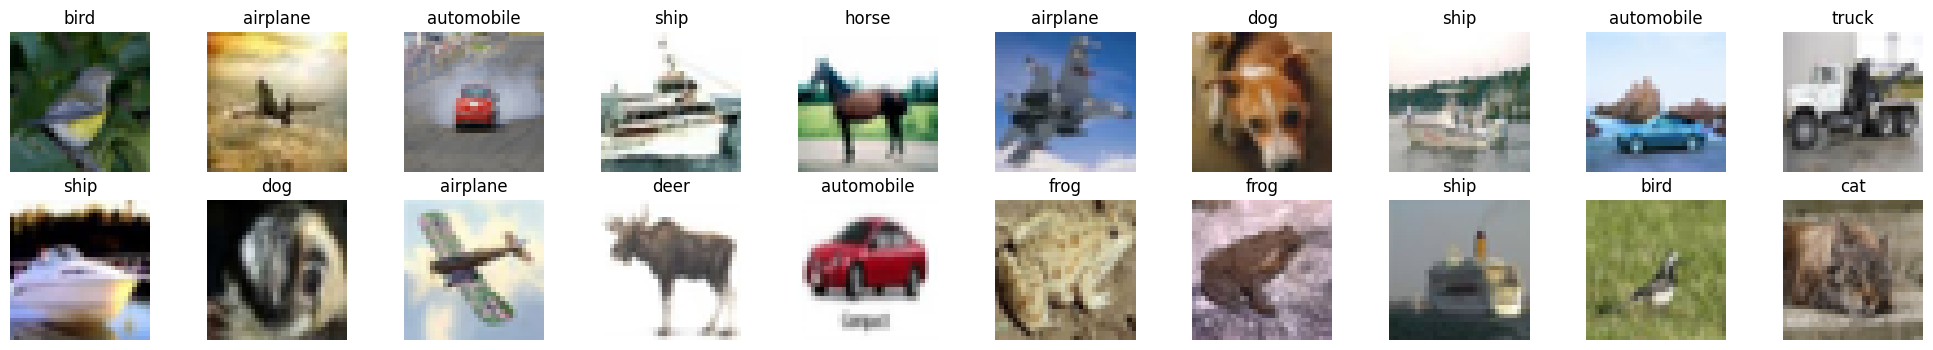

In [8]:
# helper function to display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")
    
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### 2. Fetch Pretrained Model

In [9]:
model = torchvision.models.resnet50(pretrained=True)

n_classes = len(classes)
n_inputs = model.fc.in_features

# modify the head so it now outputs 10 classes
model.fc = nn.Linear(n_inputs, n_classes)

frozen_parameters = []

# Freeze the pretrained parameters
for p in model.parameters():
    if p.requires_grad:
        p.requires_grad = False
        frozen_parameters.append(p)        

print(f"Froze {len(frozen_parameters)} groups of parameters")

# thaw the parameters of the head so we can, optionally, train only the head
for p in model.fc.parameters():
    p.requires_grad = True

Froze 161 groups of parameters


### 3. Train(Tune) the model

#### 3.1 Use Pretrained Model and Fine-Tune

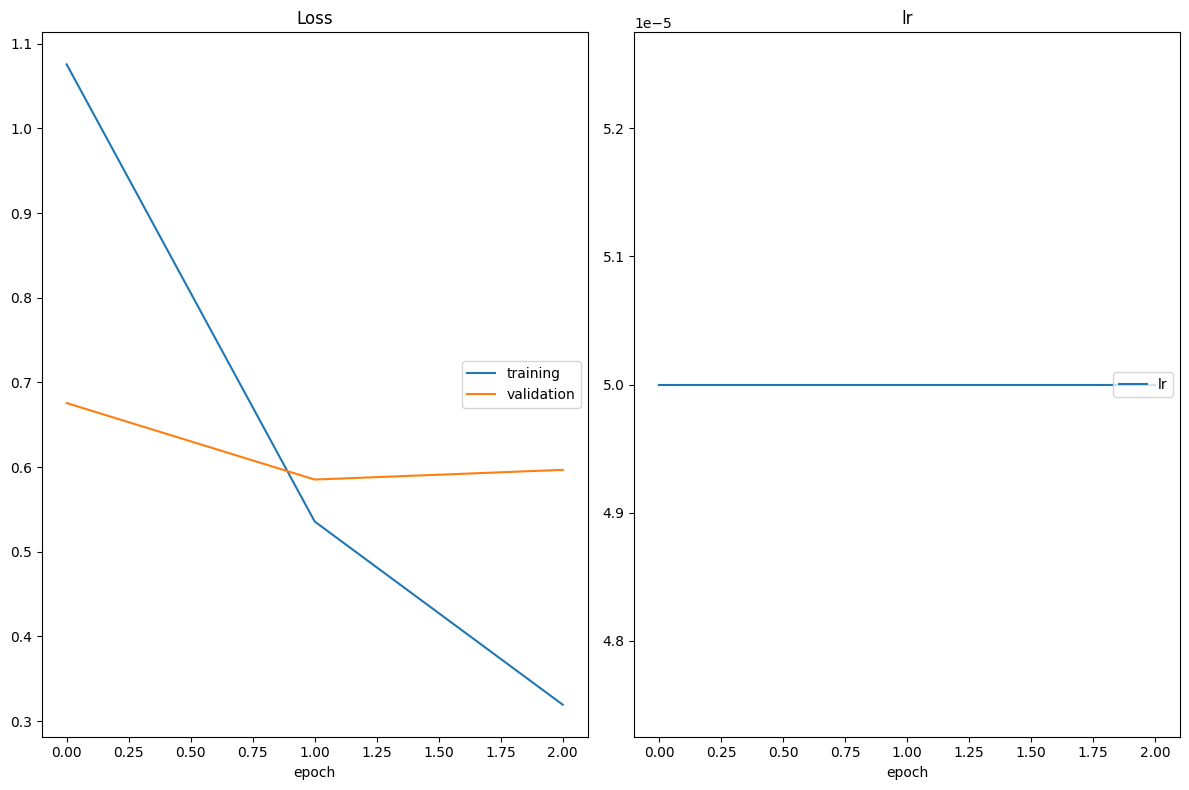

Training:  57%|█████████████████▊             | 359/625 [00:34<00:13, 20.20it/s]

In [ ]:
# Thaw parameters we had frozen before
for p in frozen_parameters:
    p.requires_grad = True
    
n_epochs = 5
lr = 0.005 / 100  # use a very small learning rate

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

optimize(
    data_loaders, 
    model, 
    optimizer, 
    loss, 
    n_epochs, 
    save_path='initial.pt',
    interactive_tracking=True
)

In [23]:
# trained on colab because it was too slow on mac
model.load_state_dict(torch.load('Fine_Tuned_ResNet50.pt', map_location=torch.device('cpu')))
test_loss, preds, actuals = test_one_epoch(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 157/157 [01:56<00:00,  1.35it/s]

Test Loss: 0.589912


Test Accuracy: 80% (8005/10000)


#### 3.2 Use Custom Network

In [5]:
model = MyCNN(n_classes=10) # defined earlier

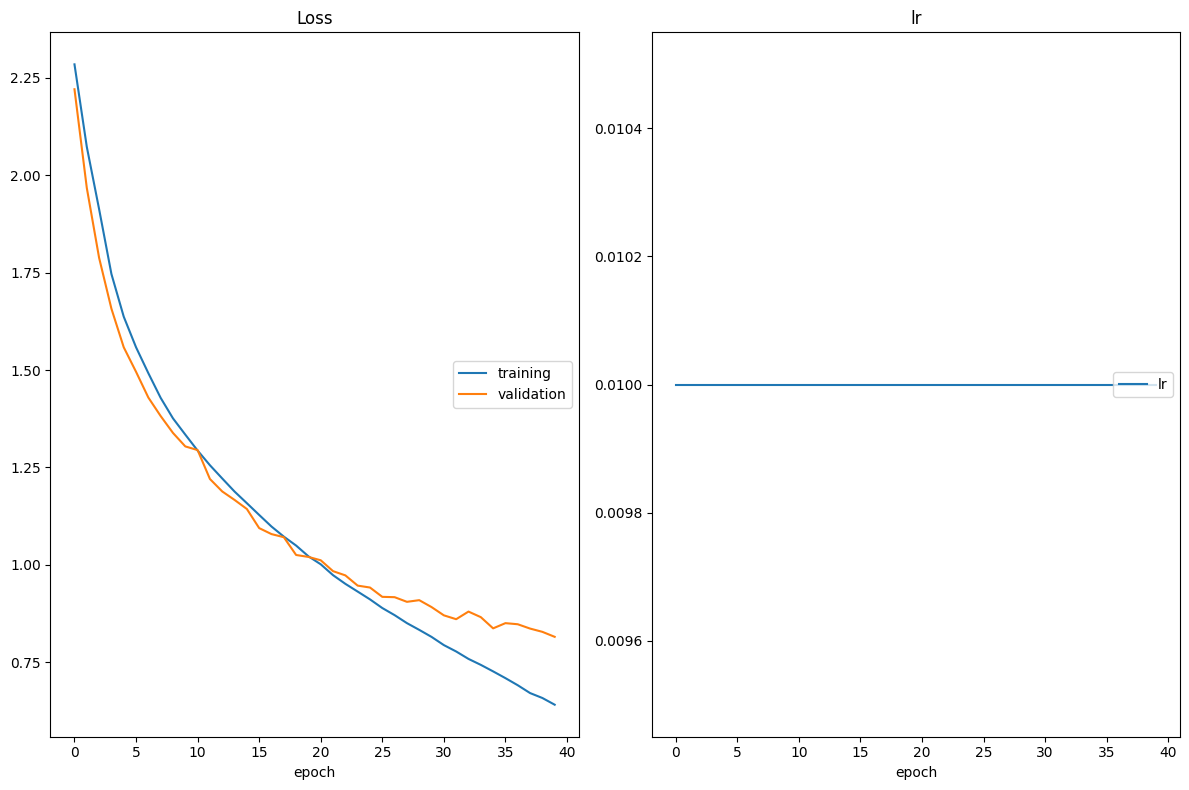

In [6]:
n_epochs = 40
lr = 0.01

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

optimize(
    data_loaders, 
    model, 
    optimizer, 
    loss, 
    n_epochs, 
    'initial.pt',
    interactive_tracking=True
)

In [7]:
model.load_state_dict(torch.load('initial.pt'))
test_loss, preds, actuals = test_one_epoch(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 157/157 [01:22<00:00,  1.91it/s]

Test Loss: 0.823448


Test Accuracy: 71% (7162/10000)
